In [1]:
##
## ResNet50 смотрим результативность (реализация взята с github keras/application):
##                  https://github.com/fchollet/keras/tree/master/keras/applications
##
## 2017-07-16
##
##  Смотрим результативность на наборах 224x244x3 JPG 
##
##
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D

from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
len(labels_df.tags.unique())

449

In [15]:
#!rm ../Temp/Batch/*.npy

In [16]:
# TODO: сделать все файлы одинаковыми, размера size. Касается последнего, связано с краевыми круговой эффектами выборки в конце.

def generate_batches ( names_tags_df, dirIn, output_shape, classes=17, ext='.jpg', size=5000) :
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.zeros((size,classes),dtype=np.uint8);
    
    iijj = 0;
    
    for ii in range(0,len(names_tags_df),size) :
        yy    = labels_df[ii:min(ii+size,len(names_tags_df))].values[:,2:].astype(np.uint8);
        files = labels_df[ii:min(ii+size,len(names_tags_df))].image_name.tolist()
        files = [x+ext for x in files]
        if len(files)<size :
            xx = np.zeros((len(files),output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
        xx    = preprocess_input(xx)
        filexx= '../Temp/BatchN/batch-{}-{}x{}x{}-XX.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        fileyy= '../Temp/BatchN/batch-{}-{}x{}x{}-YY.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        np.save(filexx,xx)
        np.save(fileyy,yy)

In [17]:
# Препростройка для быстрой подачи batches
print(datetime.datetime.now())
##generate_batches(labels_df,trDirJPG,(224,224,3))
print(datetime.datetime.now())

2017-07-16 13:47:56.670557
2017-07-16 13:50:17.542210 --> 5000
2017-07-16 13:52:10.737408 --> 10000
2017-07-16 13:54:39.562434 --> 15000
2017-07-16 13:57:12.832186 --> 20000
2017-07-16 13:59:24.678649 --> 25000
2017-07-16 14:01:55.349893 --> 30000
2017-07-16 14:04:04.832081 --> 35000
2017-07-16 14:06:30.966921 --> 40000
2017-07-16 14:07:18.148274


In [17]:
def get_train (batch_size, n0, ns, dirIn='../Temp/BatchN', size=5000, output_shape=(224,224,3), max_fi=40000, debugOK=False):
    
    def get_new_fi (fi, bi, gi) :
        fi_old = fi
        while ((bi+batch_size)>size) or ((gi+1)>=n0+ns) : 
            fi  = (fi + size) if ((gi<(n0+ns))and ((fi+size)<=max_fi)) else (n0/size)*size;
            bi  = (n0-fi) if fi<=n0 else 0
            gi  = fi+bi
        return (fi,bi,gi)
        
    
    assert (batch_size<=size)
    assert ((max_fi/size)>1) or ((n0+batch_size)<=size)
        
    while 1:
        
        fi       = (n0/size)*size
        bi       = (n0-fi) if fi<=n0 else 0
        gi       = fi+bi
        
        fi,bi,gi = get_new_fi (fi,bi,gi)
        
        if debugOK : print(datetime.datetime.now(),'g read fi={} bi={} gi={} batch_size={} n0={} ns={} dirIn={}'.
                           format(fi,bi,gi,batch_size,n0,ns,dirIn))
            
        fx = 'batch-{}-{}x{}x{}-XX.npy'
        fy = 'batch-{}-{}x{}x{}-YY.npy'
        xx = np.load(os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2])));
        yy = np.load(os.path.join(dirIn,fy.format(fi,output_shape[0],output_shape[1],output_shape[2])));
        old_fi = fi
    
        while True :
            if ((bi+batch_size)>yy.shape[0]) or ((gi+1)>=n0+ns) :
                fi,bi,gi = get_new_fi (fi,bi,gi)
    
                if debugOK : print(datetime.datetime.now(),'get_train read fi={} bi={} gi={}'.format(fi,bi,gi))
            
                if (fi<>old_fi) :
                    xx = np.load(os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2])));
                    yy = np.load(os.path.join(dirIn,fy.format(fi,output_shape[0],output_shape[1],output_shape[2])));
                    old_fi = fi

                if debugOK : print(datetime.datetime.now(),'get_train xx={} yy={} fx={}'.
                                   format(xx.shape,yy.shape,
                                          os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2]))))
                
            
            xxx, yyy, bi, gi = xx[bi:bi+batch_size], yy[bi:bi+batch_size], bi+batch_size, gi+batch_size
            #if debugOK : print(datetime.datetime.now(),
            #                   'get_train get  fi={} bi={} gi={} xxx={} yyy={}'.format(fi,bi,gi,xxx.shape,yyy.shape))
            
            yield (xxx, yyy)

In [18]:
#xx = get_train(128,4873,2000,debugOK=True)
#for ii in range(4) : xx.next()


In [19]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [20]:
sizing = (224,224,3)
batch_size = 32
input_shape, output_classes, metric = sizing, 17, 'acc'
print(input_shape,output_classes)

(224, 224, 3) 17


In [21]:
K.clear_session()
base_model = ResNet50(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

x = base_model.output

##print(base_model.summary())

##x = GlobalMaxPooling2D()(x) 
x = Flatten()(x)
initiaze = 'he_normal'

x = Dense(4096, kernel_initializer=initiaze, name='dense1')(x)
x = Dropout(0.20)(x)
x = Dense(4096, kernel_initializer=initiaze, name='dense2')(x)
x = Dropout(0.20)(x)
##x = Dense(4096, kernel_initializer=initiaze, name='dense3')(x)
##x = Dropout(0.15)(x)
##x = Dense(2048, kernel_initializer=initiaze, name='dense4')(x)
##x = Dropout(0.25)(x)


# and a logistic layer -- let's say we have 200 classes
predictions = Dense(output_classes, activation='softmax', name='predictions')(x)

# this is the model we will train
model10 = Model(inputs=base_model.input, outputs=predictions)


###for layer in base_model.layers : layer.Tranable = False

sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

#model10.summary()

In [22]:
if False :
    model10 = load_model('../Data-Keras/Models/model-ResNet50-224x224x3-d4096xd4096.h5')

In [24]:
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [29]:
if False : 
    sweight  = np.zeros(trY.shape[0],dtype=np.float32);
    sweight[:]  = 1.0
    sweight[trY[:,0]==1] = 0.35
    sweight[trY[:,1]==1] = 0.25
    sweight[trY[:,2]==1] = 0.15
    sweight[trY[:,3]==1] = 0.05

In [ ]:
epochs     = 35
verbose    = 2
stopping   = 10

prefixTemp = 'ResNet50G-jpg-tif-{}x{}x{}'.format(sizing[0],sizing[1],sizing[2])     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

filepath="../Temp/Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-D4096x2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

step = 10000
low  = 0
high = low+step

xxyy = 0
#trXX = trX #[trY[:,xxyy]==1]
#trYY = trY #[trY[:,xxyy]==1]

lb_df = labels_df[:40000] # пока последний файл не добьется поворотами изображений
#lb_df = labels_df[low:high]
split = len(lb_df)-int(len(lb_df)/5.0)
generate, validate = lb_df[:split], lb_df[split:]

print(datetime.datetime.now())
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit_generator( get_train(batch_size,0,len(generate),debugOK=False),
                    epochs=epochs, 
                    steps_per_epoch=int(len(generate)/batch_size),
                    validation_data=get_train(batch_size,split,len(validate),debugOK=False),
                    validation_steps=int(len(validate)/batch_size),
                    #### ???? max_queue_size=100,
                    initial_epoch = 11,
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-18 01:46:31.515549
Epoch 12/35


In [1]:
#fc1[1].shape, fc1[1][:10], fc2[0][:10], fc2[1][:10], ffcc[0][:10], ffcc[1][:10]

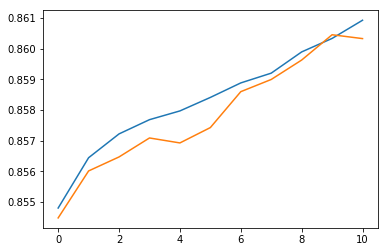

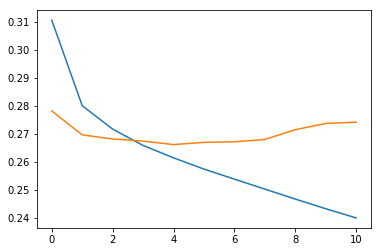

In [48]:
#sgd.get_config(); hist1.history
plt.plot(hist1.history['acc']); plt.plot(hist1.history['val_acc']); plt.show()
plt.plot(hist1.history['loss']); plt.plot(hist1.history['val_loss']); plt.show()
#hist1.history

In [27]:
#
#  Построение решения для train массива
#

# train

train = get_train(5000,0,len(labels_df),debugOK=False);

Flag, i, load_size = True, 0, 0;
try : 
    while Flag :
            xx,yy = train.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),'load   : ',i,load_size,xx.shape,yy.shape) #,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])

            pp   = model10.predict(xx, batch_size=batch_size)
            if (i==1) :
                trP = pp
                trY = yy
            else :
                trP = np.vstack([trP,pp])
                trY = np.vstack([trY,yy])

            if trY.shape[0]>=len(labels_df) : Flag = False;
            print(datetime.datetime.now(),'predict: ',i,trP.shape,trY.shape,Flag) #,trY[0],trY[-1])

except StopIteration as e : Flag = False;
        
finally : train.close();

# Уровни прохождения & решение
###trO01   = getProbX01(trOP,th)


2017-07-18 00:58:05.656699 load   :  1 5000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 00:59:14.826497 predict:  1 (5000, 17) (5000, 17) True
2017-07-18 00:59:38.899373 load   :  2 10000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 01:00:47.252625 predict:  2 (10000, 17) (10000, 17) True
2017-07-18 01:01:12.220189 load   :  3 15000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 01:02:20.557508 predict:  3 (15000, 17) (15000, 17) True
2017-07-18 01:02:45.702525 load   :  4 20000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 01:03:54.031625 predict:  4 (20000, 17) (20000, 17) True
2017-07-18 01:04:19.370463 load   :  5 25000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 01:05:27.867681 predict:  5 (25000, 17) (25000, 17) True
2017-07-18 01:05:53.664669 load   :  6 30000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 01:07:02.010916 predict:  6 (30000, 17) (30000, 17) True
2017-07-18 01:07:27.506602 load   :  7 35000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 01:08:35.588598 predict:  7 (35000, 17) (35000, 17) 

In [28]:
##%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
th, _       = getTh(trY,trP)
trP01x      = getProbX01(trP,th)

In [29]:
#print(model10.evaluate(trX,trY,verbose=2,batch_size=batch_size))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
if trY.shape[1]==17 :
    print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
    print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

(40479, 17)
(40479, 17)
fbeta_score= 0.296713696944


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


fbeta_pred = 0.519458381501
fbeta_score= 0.906280423176
fbeta_pred = 0.912937779993


In [46]:
if True :
    save_model(model10,'../Data-Keras/Models/model-ResNet50-224x224x3-d4096x2.h5')
    model10.save_weights('../Data-Keras/Models/model-ResNet50-224x224x3-d-weights.h5')
    if False : # best 0x90004
        save_model(model10,'../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096.h5')
        model10.save_weights('../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096-weights.h5')
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP01-XX.npy',trP01)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP-XX.npy', trP)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIY-YY.npy',trY)

In [47]:
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [31]:
trP[0], trY[0], trP01[0], trP01x[0]

(array([  3.01790982e-01,   5.20674348e-01,   4.31234296e-03,
          1.64743364e-01,   1.43059925e-03,   7.40108517e-05,
          2.55870190e-03,   5.60992921e-04,   1.60275144e-04,
          4.31659544e-04,   8.40873225e-04,   1.08623448e-04,
          4.74930304e-04,   8.34448438e-05,   1.16859365e-03,
          2.18034373e-04,   3.68403504e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [139]:
# Результативность

In [32]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg224 (epoch=15,features=17) ResNet50 d4096x2 +imnet

0 acc=0.967489315448 roc=0.818862649722 not=1316 yes=1746 no=37417 true=39163 all-1-0=(0.6474-0.9903)
1 acc=0.965883544554 roc=0.856462760251 not=1381 yes=36938 no=2160 true=39098 all-1-0=(0.9847-0.7283)
2 acc=0.905135996443 roc=0.889559559019 not=3840 yes=10465 no=26174 true=36639 all-1-0=(0.8498-0.9293)
3 acc=0.958002915092 roc=0.940760300397 not=1700 yes=27958 no=10821 true=38779 all-1-0=(0.9834-0.8982)
4 acc=0.926060426394 roc=0.848061744744 not=2993 yes=5373 no=32113 true=37486 all-1-0=(0.7250-0.9711)
5 acc=0.953284419081 roc=0.826927895834 not=1891 yes=2462 no=36126 true=38588 all-1-0=(0.6727-0.9812)
6 acc=0.932187059957 roc=0.878143414068 not=2745 yes=6362 no=31372 true=37734 all-1-0=(0.7883-0.9680)
7 acc=0.922478322093 roc=0.718877917176 not=3138 yes=2048 no=35293 true=37341 all-1-0=(0.4574-0.9803)
8 acc=0.994886237308 roc=0.504784688995 not=207 yes=2 no=40270 true=40272 all-1-0=(0.0096-1.0000)
9 acc=0.983028236864 roc=0.952803475355 not=687 yes=1920 no=37872 true=39792 all-1-0

In [117]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg224 (epoch=15,features=17) ResNet50 d2048x2 +imnet

0 acc=0.965340052867 roc=0.811857957562 not=1403 yes=1712 no=37364 true=39076 all-1-0=(0.6348-0.9889)
1 acc=0.96212851108 roc=0.846674371136 not=1533 yes=36836 no=2110 true=38946 all-1-0=(0.9820-0.7114)
2 acc=0.894612021048 roc=0.877381470735 not=4266 yes=10263 no=25950 true=36213 all-1-0=(0.8334-0.9214)
3 acc=0.948738852244 roc=0.927421574474 not=2075 yes=27865 no=10539 true=38404 all-1-0=(0.9801-0.8748)
4 acc=0.914128313446 roc=0.822489536614 not=3476 yes=5024 no=31979 true=37003 all-1-0=(0.6779-0.9671)
5 acc=0.94960349811 roc=0.784303898691 not=2040 yes=2132 no=36307 true=38439 all-1-0=(0.5825-0.9861)
6 acc=0.921811309568 roc=0.859428272138 not=3165 yes=6099 no=31215 true=37314 all-1-0=(0.7557-0.9632)
7 acc=0.914029496776 roc=0.69368927423 not=3480 yes=1839 no=35160 true=36999 all-1-0=(0.4108-0.9766)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.979199090887 roc=0.94920044725 not=842 yes=1913 no=37724 true=39637 all-1-0=(0.

In [312]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet LB=0.90004

0 acc=0.970824378073 roc=0.827535509167 not=1181 yes=1786 no=37512 true=39298 all-1-0=(0.6622-0.9929)
1 acc=0.976555744954 roc=0.877590365212 not=949 yes=37271 no=2259 true=39530 all-1-0=(0.9935-0.7616)
2 acc=0.917611601077 roc=0.909720294098 not=3335 yes=10955 no=26189 true=37144 all-1-0=(0.8896-0.9299)
3 acc=0.964376590331 roc=0.949960875432 not=1442 yes=28021 no=11016 true=39037 all-1-0=(0.9856-0.9143)
4 acc=0.937943131006 roc=0.87391779368 not=2512 yes=5728 no=32239 true=37967 all-1-0=(0.7729-0.9749)
5 acc=0.954074952444 roc=0.807677321803 not=1859 yes=2302 no=36318 true=38620 all-1-0=(0.6290-0.9864)
6 acc=0.942711035352 roc=0.901277662688 not=2319 yes=6718 no=31442 true=38160 all-1-0=(0.8324-0.9702)
7 acc=0.928012055634 roc=0.768147534975 not=2914 yes=2520 no=35045 true=37565 all-1-0=(0.5629-0.9734)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.990464191309 roc=0.950839323708 not=386 yes=1894 no=38199 true=40093 all-1-0=(

In [22]:
if True :
    K.clear_session()
    model10 = load_model('../Data-Keras/Models/model-ResNet50-224x224x3-d.h5')
    model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [50]:
#model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [33]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

NameError: name 'trX' is not defined

In [34]:
def generate_test ( dirIn, output_shape, size=5000, debugOK=False) :
    
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.array((size,output_shape[0],output_shape[1],output_shape[2]));
    
    iijj = 0;
    
    names_files = np.array(os.listdir(dirIn));
    if debugOK : 
        print('generate_test: names_files={} size={} dirIn={}'.format(len(names_files),size,dirIn))
        names_files = names_files[:1000]
        print(names_files.shape)
    
    for ii in range(0,names_files.shape[0],size) :
        ###if debugOK : print('generate_test: ii={}'.format(ii))
        yy    = names_files[ii:min(ii+size,names_files.shape[0])];
        files = names_files[ii:min(ii+size,names_files.shape[0])].tolist()
        #################files = [x+ext for x in files]
        if len(files)<size :
            xx = np.zeros((len(files),output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            ##if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
        xx    = preprocess_input(xx)
        yield xx,yy

In [120]:
if False : # small testing
    test = generate_test(teDirJPG,sizing,size=10000,debugOK=True);
    Flag, i, load_size = True, 0, 0;
    while Flag :
        try : 
            xx,yy = test.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),i,load_size,xx.shape,yy.shape,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])
        except StopIteration as e : Flag = False;
    test.close();


In [35]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test

test = generate_test(teDirJPG,sizing,size=10000,debugOK=False);
Flag, i, load_size = True, 0, 0;
try : 
    while True :
            xx,yy = test.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),'load   : ',i,load_size,xx.shape,yy.shape,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])

            pp   = model10.predict(xx, batch_size=batch_size)
            if (i==1) :
                trOP = pp
                trOY = yy
            else :
                trOP = np.vstack([trOP,pp])
                trOY = np.hstack([trOY,yy])

            print(datetime.datetime.now(),'predict: ',i,trOP.shape,trOY.shape,trOY[0],trOY[-1])

except StopIteration as e : Flag = False;
        
finally : test.close();

# Уровни прохождения & решение
trO01   = getProbX01(trOP,th)


2017-07-18 01:19:11.662789 load   :  1 10000 (10000, 224, 224, 3) (10000,) test_10002.jpg test_19029.jpg
2017-07-18 01:21:31.519170 predict:  1 (10000, 17) (10000,) test_10002.jpg test_19029.jpg
2017-07-18 01:21:57.320222 load   :  2 20000 (10000, 224, 224, 3) (10000,) test_1903.jpg test_28015.jpg
2017-07-18 01:24:14.656375 predict:  2 (20000, 17) (20000,) test_10002.jpg test_28015.jpg
2017-07-18 01:24:39.119299 load   :  3 30000 (10000, 224, 224, 3) (10000,) test_28016.jpg test_37026.jpg
2017-07-18 01:26:59.221651 predict:  3 (30000, 17) (30000,) test_10002.jpg test_37026.jpg
2017-07-18 01:27:24.185759 load   :  4 40000 (10000, 224, 224, 3) (10000,) test_37027.jpg test_9402.jpg
2017-07-18 01:29:41.004404 predict:  4 (40000, 17) (40000,) test_10002.jpg test_9402.jpg
2017-07-18 01:30:06.289252 load   :  5 50000 (10000, 224, 224, 3) (10000,) test_9403.jpg file_18419.jpg
2017-07-18 01:32:26.429898 predict:  5 (50000, 17) (50000,) test_10002.jpg file_18419.jpg
2017-07-18 01:33:10.504380 lo

In [36]:
trOP[0]

array([  1.20915584e-02,   7.79595673e-02,   1.57023594e-02,
         2.39090458e-01,   3.87971133e-01,   1.05419895e-03,
         4.24686447e-03,   5.03548072e-04,   3.23220273e-04,
         2.16768622e-01,   1.26272265e-03,   3.86463886e-04,
         4.17670794e-02,   2.96551589e-04,   1.40534656e-04,
         1.71748121e-04,   2.63234484e-04], dtype=float32)

In [37]:
#trO01[0:3],np.array(th),trOP[0:3]
if False :
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trO01-OX.npy',trO01)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOP-OX.npy', trOP)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOY-OY.npy',trOY)

In [38]:
# Строим результат

In [39]:
trZ = trO01
trOY_old = trOY
trOY_old[0]

'test_10002.jpg'

In [40]:
trOY = trOY_old.tolist(); type(trOY), len(trOY)
trOY = [os.path.splitext(xx)[0] for xx in trOY]; trOY[0]

'test_10002'

In [42]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [43]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary clear'],
 ['test_4', 'cloudy']]

In [44]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-18-01-36-53


In [45]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,cloudy


In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Склад барахла

In [ ]:
Skip to content
Features Business Explore Marketplace Pricing
This repository
Search
Sign in or Sign up
 Watch 1,176  Star 17,415  Fork 6,223 fchollet/keras
 Code  Issues 1,167  Pull requests 36  Projects 1  Wiki Insights 
Branch: master Find file Copy pathkeras/keras/applications/vgg19.py
bac1637  on 22 May
@taehoonlee taehoonlee Fix typos (#6702)
4 contributors @fchollet @taehoonlee @singlas @ozancaglayan
RawBlameHistory     
193 lines (167 sloc)  8.29 KB
# -*- coding: utf-8 -*-
"""VGG19 model for Keras.
# Reference
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from ..models import Model
from ..layers import Flatten
from ..layers import Dense
from ..layers import Input
from ..layers import Conv2D
from ..layers import MaxPooling2D
from ..layers import GlobalAveragePooling2D
from ..layers import GlobalMaxPooling2D
from ..engine.topology import get_source_inputs
from ..utils import layer_utils
from ..utils.data_utils import get_file
from .. import backend as K
from .imagenet_utils import decode_predictions
from .imagenet_utils import preprocess_input
from .imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG19(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG19 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model
Contact GitHub API Training Shop Blog About
© 2017 GitHub, Inc. Terms Privacy Security Status Help

In [ ]:
def VGG16 ( include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [209]:
if False :
    from keras.utils.data_utils import get_file
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
    WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        WEIGHTS_PATH,
                                        cache_subdir='models')


In [ ]:
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models')
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models')

In [27]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    
    model = Kriz2012(model,iSize,rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)



In [93]:
K.clear_session()

In [83]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

#model = VGG16(weights='imagenet', include_top=False)
model10 = VGG16(weights=None,input_shape=(224,224,3),include_top=True,classes=4)

#x = (Dense(512,activation='relu'))(model10)
#model10.add(Dropout(0.25))
#model10.add(Dense(4,activation='sigmoid'))

#img_path = 'elephant.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

#features = model.predict(x)

In [114]:
#model10.summary()